In [65]:
import os
import numpy as np
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import functions as fct

In [86]:
# Load the data from the CSV files
metadata_df = pd.read_csv("data/plate_metadata.csv", skipinitialspace=True, quotechar="'")
morphometry_df = pd.read_csv("data/median_morphometry_per_site.csv",skipinitialspace=True, quotechar="'")
unique_components = metadata_df['batch_id'].unique()
print("components we are observing",unique_components)
# exchanging the components with an integer for analysis
mapping = {k: v for v, k in enumerate(metadata_df['batch_id'].unique())}
inv_mapping = {v: k for k, v in mapping.items()}
print("components mapped",mapping)
metadata_df['mapped_batch_id'] = metadata_df['batch_id'].map(mapping)

control_mapping = {k: v for v, k in enumerate(metadata_df['pert_type'].unique())}
inv_control_mapping = {v: k for k, v in control_mapping.items()}
metadata_df['mapped_control'] = metadata_df['pert_type'].map(control_mapping)
print("control types",control_mapping)


components we are observing ['Etoposide' 'Dimethyl Sulfoxide' 'D-Sorbitol' 'Paclitaxel']
components mapped {'Etoposide': 0, 'Dimethyl Sulfoxide': 1, 'D-Sorbitol': 2, 'Paclitaxel': 3}
control types {'poscon': 0, 'negcon': 1}


In [87]:
# Simplify the metadata

# ASSUMPTION on the observed well metadata: as a single well_id is referenced multiple times, I arbitrarily select the well belonging to the most recent barcode
# Convert barcode column to numeric after removing the first two characters
metadata_df['barcode_numeric'] = metadata_df['barcode'].str[2:].astype(int)
# Find the index of the row with the smallest barcode_numeric value for each unique well_id
idx_min_barcode = metadata_df.groupby('well_id')['barcode_numeric'].idxmin()
# Select rows with the indices found
metadata_filtered = metadata_df.loc[idx_min_barcode]
# Drop the temporary column
metadata_filtered.drop(columns=['barcode_numeric'], inplace=True)
# Now metadata_df_filtered contains only the rows with the smallest barcode[2:] value for each unique well_id
metadata_df = metadata_filtered

# Calculate compound weight and add it as a new column
metadata_df['cpmd_pg'] = metadata_df.apply(fct.calculate_compound_weight, axis=1)
metadata_df.drop(columns=['cmpd_vol', 'cmpd_vol_unit','cmpd_conc', 'cmpd_conc_unit' ], inplace=True)

if (metadata_df['solvent'] == 'DMSO').all():
    metadata_df['dmso_mM'] = metadata_df.apply(fct.calculate_stock_in_mM, axis=1)
    metadata_df.drop(columns=['solvent', 'stock_conc_unit', 'stock_conc'], inplace=True)
else:
    other_solvents = metadata_df.loc[metadata_df['solvent'] != 'DMSO', 'solvent'].unique()
    print("Different solvents:", other_solvents)

# Remove the non relevant columns for tsne from metadata_df
# these data are redundant with the well_ID
del metadata_df['external_id']
del metadata_df['layout_id']

column_names = metadata_df.columns.tolist()
for elem in column_names:
    if len(metadata_df[elem].unique()) == 1 :
        #print("redundant across all wells: deleting", elem)
        del metadata_df[elem]
    else:
        print("keeping", elem)
# Merge the DataFrames on the 'well_id' column
combined_df = pd.merge(metadata_df, morphometry_df, on='well_id')
# Define the desired column order
desired_columns = ['well_id','barcode', 'mapped_batch_id','mapped_control', 'cpmd_pg', 'dmso_mM', 'pert_type','site_id', 'cell_tot', 'area', 'min_diameter', 'max_diameter', 'seeded', 'painted']
# Reorder the columns
combined_df = combined_df.reindex(columns=desired_columns)
combined_df.to_csv("data/combined_data.csv", index=False)


keeping barcode
keeping well_id
keeping pert_type
keeping batch_id
keeping seeded
keeping painted
keeping mapped_batch_id
keeping mapped_control
keeping cpmd_pg
keeping dmso_mM


cell_tot area min_diameter max_diameter cpmd_pg


C:\Users\clara\AppData\Local\Temp\ipykernel_18760\1679972876.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



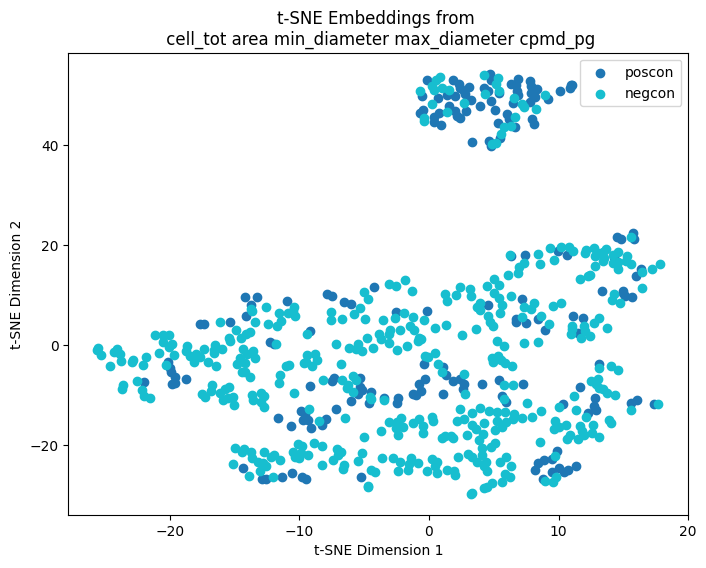

C:\Users\clara\AppData\Local\Temp\ipykernel_18760\1679972876.py:40: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



cell_tot area min_diameter max_diameter cpmd_pg


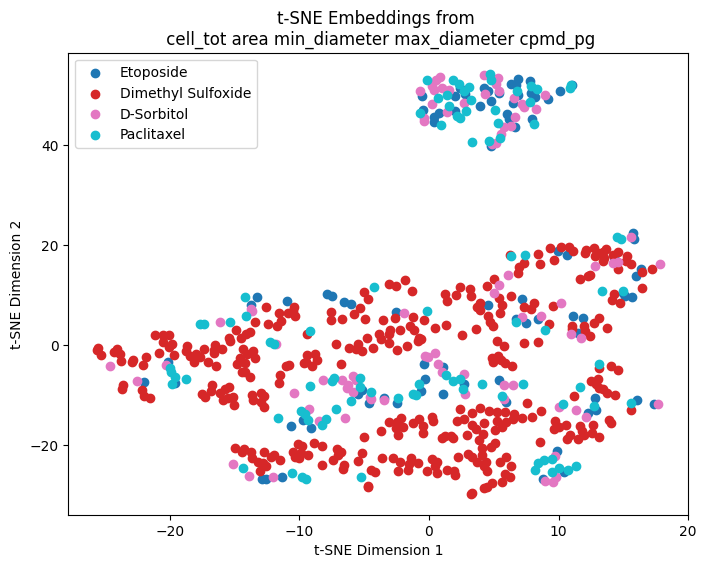

In [91]:
# Preprocess the data
metrics = ['cell_tot', 'area', 'min_diameter', 'max_diameter', 'cpmd_pg'] 
X = combined_df[metrics].values 
X = StandardScaler().fit_transform(X)  # Standardize the features

# Compute t-SNE embeddings
tsne = TSNE(learning_rate=50,random_state=42) #perplexity=3 # n_components=2,
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(X_tsne, columns=['tsne_x', 'tsne_y'])


# Looking at the distribution with control type colormap
tsne_df['label'] = combined_df['mapped_control']  
# Assuming you already have 'tsne_df' DataFrame with t-SNE coordinates and 'label' column
# Create a list of unique labels (integer values)
unique_labels = sorted(tsne_df['label'].unique())
# Create a colormap with distinct colors for each label
colors = plt.cm.get_cmap('tab10', len(unique_labels))
# Plot each label separately with its corresponding color
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    label_data = tsne_df[tsne_df['label'] == label]
    plt.scatter(label_data['tsne_x'], label_data['tsne_y'], color=colors(i), label=inv_control_mapping[label])
metrics_string = ' '.join(x for x in metrics)
print(metrics_string)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Embeddings from \n '+metrics_string)
plt.legend()
plt.savefig("data/t-SNE-per_control_type.png")
plt.show()


# Looking at the distribution with compound type colormap
tsne_df['label'] = combined_df['mapped_batch_id']  
# Assuming you already have 'tsne_df' DataFrame with t-SNE coordinates and 'label' column
# Create a list of unique labels (integer values)
unique_labels = sorted(tsne_df['label'].unique())
# Create a colormap with distinct colors for each label
colors = plt.cm.get_cmap('tab10', len(unique_labels))
# Plot each label separately with its corresponding color
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    label_data = tsne_df[tsne_df['label'] == label]
    plt.scatter(label_data['tsne_x'], label_data['tsne_y'], color=colors(i), label=inv_mapping[label])
metrics_string = ' '.join(x for x in metrics)
print(metrics_string)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Embeddings from \n '+metrics_string)
plt.legend()
plt.savefig("data/t-SNE-per_compound_type.png")
plt.show()